<a href="https://colab.research.google.com/github/smitasasindran/era4/blob/session7/Session7/ERA4_Session7_Iteration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding layers as per assignment

1. Depthwise Separable Convolution (anywhere except the first block)
2. Dilated Convolution (in last block)
3. RF more than 44




## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np


In [ ]:
!pip install albumentations
import albumentations as A

## Data Transformations

In [ ]:
#Train Phase transformations
train_transforms = transforms.Compose([
    # A.HorizontalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
])



## Dataset and Creating Train/Test Split


In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170M/170M [00:04<00:00, 41.4MB/s]


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 512#256
cpu_batch_size = 128#64
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Data Statistics

torch.Size([512, 3, 32, 32])
torch.Size([512])


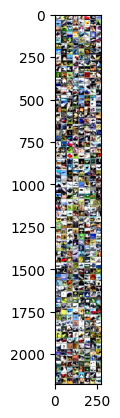

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog  ship  deer  deer  truck truck deer  horse cat   dog   truck truck dog   deer  car   dog   car   dog   dog   deer  truck bird  frog  ship  dog   ship  dog   frog  ship  car   dog   car   horse ship  frog  deer  deer  ship  cat   cat   frog  horse ship  horse car   car   truck bird  bird  dog   ship  truck cat   ship  deer  deer  dog   car   ship  dog   horse deer  cat   deer  car   dog   plane bird  truck cat   cat   cat   ship  horse frog  plane dog   bird  truck frog  dog   car   car   horse plane truck cat   bird  car   cat   car   deer  car   ship  horse plane frog  dog   truck deer  bird  car   deer  hors

In [ ]:
# Check some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# img = np.moveaxis(images[0].numpy(), 0, -1)
# plt.imshow(img)

def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))



# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Define the model

In [ ]:
#https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch
def depthwise_separable_layer(nin, nout, dropout_value, padding=0):
    depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=padding, groups=nin, bias=False)
    pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=False)

    depthwise_separable = nn.Sequential(
        depthwise,
        nn.ReLU(),
        nn.BatchNorm2d(nin),
        nn.Dropout(dropout_value),
        pointwise,
        nn.ReLU(),
        nn.BatchNorm2d(nout),
        nn.Dropout(dropout_value)
    )
    return depthwise_separable


In [ ]:
# dropout_value = 0.1

# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()

#         # Conv Block 1
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
#         ) # output_size = 32, rf=3

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 32, rf=5

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 32, rf=7

#         # transition 1 - use stride2 instead of MP
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=9
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=9

#         # Conv Block 2 -------------------
#         self.conv6 = nn.Sequential( # padding
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=13 (jump2)

#         self.conv7 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=17

#         self.conv8 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=21

#         # Transition 2 --
#         self.conv9 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=21


#         # Conv Block 3 ---------------------
#         self.conv10 = nn.Sequential( # padding
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 15, rf=25

#         self.conv11 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 13, rf=29

#         # self.conv12 = nn.Sequential(
#         #     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(32),
#         #     nn.Dropout(dropout_value)
#         # ) # output_size = 11, rf=33
#         self.conv12 = depthwise_separable_layer(32, 32, dropout_value, padding=0) # output_size=11, rf=33

#         # transition 3
#         self.conv13 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
#         ) # output_size = 11, rf=33

#         # Conv Block 4 - with dilation
#         self.conv14 = nn.Sequential( # Dilation
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, dilation=2, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 7, rf=41 # dilation

#         self.conv15 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Dropout(dropout_value)
#         ) # output_size = 5, rf=45

#         # self.conv16 = nn.Sequential(
#         #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
#         #     nn.ReLU(),
#         #     nn.BatchNorm2d(64),
#         #     nn.Dropout(dropout_value)
#         # ) # output_size = 6


#         # Output
#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=5)
#         ) # output_size = 5

#         self.conv17 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(10),
#             # nn.Dropout(dropout_value)
#             # nn.ReLU()
#         ) # output_size = 10, rf=45



#     def forward(self, x):
#         # block1
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x) # stride 2
#         # print(f"conv4 out: {x.shape}")

#         # block2
#         x = self.conv5(x)
#         x = self.conv6(x)
#         x = self.conv7(x)
#         x = self.conv8(x)

#         # block3
#         x = self.conv9(x)
#         x = self.conv10(x)
#         x = self.conv11(x)
#         x = self.conv12(x)

#         # block4
#         x = self.conv13(x)
#         x = self.conv14(x)
#         x = self.conv15(x)
#         # x = self.conv16(x)
#         # print(f"conv15 out: {x.shape}")

#         # Output
#         x = self.gap(x)
#         x = self.conv17(x)
#         x = x.view(-1, 10)

#         return F.log_softmax(x, dim=-1)




In [ ]:
# updated -- more kernels

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=3

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=5

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=7

        # transition 1 - use stride2 instead of MP
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=9
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=9

        # Conv Block 2 -------------------
        self.conv6 = nn.Sequential( # padding
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=13 (jump2)

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=17

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=21

        # Transition 2 --
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=21


        # Conv Block 3 ---------------------
        self.conv10 = nn.Sequential( # padding
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=25

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 13, rf=29

        # self.conv12 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 11, rf=33
        self.conv12 = depthwise_separable_layer(32, 64, dropout_value, padding=0) # output_size=11, rf=33

        # transition 3
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 11, rf=33

        # Conv Block 4 - with dilation
        self.conv14 = nn.Sequential( # Dilation
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 7, rf=41 # dilation

        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 5, rf=45

        # self.conv16 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6


        # Output
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 5

        self.conv17 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
            # nn.ReLU()
        ) # output_size = 10, rf=45



    def forward(self, x):
        # block1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) # stride 2
        # print(f"conv4 out: {x.shape}")

        # block2
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        # block3
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)

        # block4
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        # x = self.conv16(x)
        # print(f"conv15 out: {x.shape}")

        # Output
        x = self.gap(x)
        x = self.conv17(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)




## Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 15, 15]          18,432
             ReLU-14           [-1

## Train and Test loops

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.672088623046875 Batch_id=97 Accuracy=22.05: 100%|██████████| 98/98 [00:15<00:00,  6.35it/s]



Test set: Average loss: 1.8856, Accuracy: 2937/10000 (29.37%)

EPOCH: 1


Loss=1.488625168800354 Batch_id=97 Accuracy=39.77: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]



Test set: Average loss: 1.5901, Accuracy: 4143/10000 (41.43%)

EPOCH: 2


Loss=1.2922388315200806 Batch_id=97 Accuracy=48.15: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]



Test set: Average loss: 1.3650, Accuracy: 5037/10000 (50.37%)

EPOCH: 3


Loss=1.2362226247787476 Batch_id=97 Accuracy=54.18: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 1.2327, Accuracy: 5559/10000 (55.59%)

EPOCH: 4


Loss=1.0771963596343994 Batch_id=97 Accuracy=58.36: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 1.1298, Accuracy: 5958/10000 (59.58%)

EPOCH: 5


Loss=1.1630464792251587 Batch_id=97 Accuracy=61.31: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 1.0554, Accuracy: 6217/10000 (62.17%)

EPOCH: 6


Loss=0.9260826110839844 Batch_id=97 Accuracy=63.90: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 1.0874, Accuracy: 6183/10000 (61.83%)

EPOCH: 7


Loss=1.0347654819488525 Batch_id=97 Accuracy=65.62: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.9573, Accuracy: 6630/10000 (66.30%)

EPOCH: 8


Loss=0.9907875061035156 Batch_id=97 Accuracy=67.30: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.9488, Accuracy: 6643/10000 (66.43%)

EPOCH: 9


Loss=0.7745562195777893 Batch_id=97 Accuracy=69.14: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.8594, Accuracy: 6947/10000 (69.47%)

EPOCH: 10


Loss=0.8284457325935364 Batch_id=97 Accuracy=70.15: 100%|██████████| 98/98 [00:16<00:00,  6.06it/s]



Test set: Average loss: 0.8528, Accuracy: 6995/10000 (69.95%)

EPOCH: 11


Loss=0.857833981513977 Batch_id=97 Accuracy=71.35: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.8386, Accuracy: 7045/10000 (70.45%)

EPOCH: 12


Loss=0.7959795594215393 Batch_id=97 Accuracy=72.07: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.8005, Accuracy: 7207/10000 (72.07%)

EPOCH: 13


Loss=0.8621122241020203 Batch_id=97 Accuracy=72.90: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]



Test set: Average loss: 0.7859, Accuracy: 7254/10000 (72.54%)

EPOCH: 14


Loss=0.7353618144989014 Batch_id=97 Accuracy=73.49: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.7760, Accuracy: 7283/10000 (72.83%)

EPOCH: 15


Loss=0.788934051990509 Batch_id=97 Accuracy=74.32: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.7503, Accuracy: 7342/10000 (73.42%)

EPOCH: 16


Loss=0.7225196361541748 Batch_id=97 Accuracy=75.16: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 0.7155, Accuracy: 7484/10000 (74.84%)

EPOCH: 17


Loss=0.692702054977417 Batch_id=97 Accuracy=75.47: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.6996, Accuracy: 7544/10000 (75.44%)

EPOCH: 18


Loss=0.6301234364509583 Batch_id=97 Accuracy=75.76: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.6906, Accuracy: 7576/10000 (75.76%)

EPOCH: 19


Loss=0.7047719359397888 Batch_id=97 Accuracy=76.66: 100%|██████████| 98/98 [00:15<00:00,  6.35it/s]



Test set: Average loss: 0.6951, Accuracy: 7584/10000 (75.84%)

EPOCH: 20


Loss=0.669444739818573 Batch_id=97 Accuracy=77.09: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.6816, Accuracy: 7642/10000 (76.42%)

EPOCH: 21


Loss=0.6547991037368774 Batch_id=97 Accuracy=77.11: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.6643, Accuracy: 7683/10000 (76.83%)

EPOCH: 22


Loss=0.5930120944976807 Batch_id=97 Accuracy=77.50: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 0.6551, Accuracy: 7721/10000 (77.21%)

EPOCH: 23


Loss=0.5550934076309204 Batch_id=97 Accuracy=78.14: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.6512, Accuracy: 7750/10000 (77.50%)

EPOCH: 24


Loss=0.6671510338783264 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.6329, Accuracy: 7835/10000 (78.35%)

EPOCH: 25


Loss=0.5516418218612671 Batch_id=97 Accuracy=78.68: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.6350, Accuracy: 7795/10000 (77.95%)

EPOCH: 26


Loss=0.5978503227233887 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.6179, Accuracy: 7859/10000 (78.59%)

EPOCH: 27


Loss=0.6669854521751404 Batch_id=97 Accuracy=78.95: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.6255, Accuracy: 7866/10000 (78.66%)

EPOCH: 28


Loss=0.571638822555542 Batch_id=97 Accuracy=79.79: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.6160, Accuracy: 7932/10000 (79.32%)

EPOCH: 29


Loss=0.5437343716621399 Batch_id=97 Accuracy=79.70: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]



Test set: Average loss: 0.5977, Accuracy: 7920/10000 (79.20%)

EPOCH: 30


Loss=0.5518001317977905 Batch_id=97 Accuracy=79.92: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.6054, Accuracy: 7934/10000 (79.34%)

EPOCH: 31


Loss=0.657512903213501 Batch_id=97 Accuracy=80.58: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.6093, Accuracy: 7893/10000 (78.93%)

EPOCH: 32


Loss=0.6125220060348511 Batch_id=97 Accuracy=80.45: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.5832, Accuracy: 7973/10000 (79.73%)

EPOCH: 33


Loss=0.596765398979187 Batch_id=97 Accuracy=80.67: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.5651, Accuracy: 8057/10000 (80.57%)

EPOCH: 34


Loss=0.6346754431724548 Batch_id=97 Accuracy=80.61: 100%|██████████| 98/98 [00:16<00:00,  6.05it/s]



Test set: Average loss: 0.5699, Accuracy: 8028/10000 (80.28%)

EPOCH: 35


Loss=0.4172324240207672 Batch_id=97 Accuracy=81.03: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.5670, Accuracy: 8077/10000 (80.77%)

EPOCH: 36


Loss=0.5343235731124878 Batch_id=97 Accuracy=81.46: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.5805, Accuracy: 8074/10000 (80.74%)

EPOCH: 37


Loss=0.5332283973693848 Batch_id=97 Accuracy=81.31: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.5787, Accuracy: 8020/10000 (80.20%)

EPOCH: 38


Loss=0.5621155500411987 Batch_id=97 Accuracy=81.52: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.5632, Accuracy: 8060/10000 (80.60%)

EPOCH: 39


Loss=0.5257662534713745 Batch_id=97 Accuracy=81.92: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.5534, Accuracy: 8091/10000 (80.91%)

EPOCH: 40


Loss=0.5180956721305847 Batch_id=97 Accuracy=81.87: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.5385, Accuracy: 8169/10000 (81.69%)

EPOCH: 41


Loss=0.5922059416770935 Batch_id=97 Accuracy=82.34: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]



Test set: Average loss: 0.5494, Accuracy: 8143/10000 (81.43%)

EPOCH: 42


Loss=0.5538347363471985 Batch_id=97 Accuracy=82.40: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 0.5508, Accuracy: 8124/10000 (81.24%)

EPOCH: 43


Loss=0.4006950855255127 Batch_id=97 Accuracy=82.58: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.5726, Accuracy: 8057/10000 (80.57%)

EPOCH: 44


Loss=0.5850811004638672 Batch_id=97 Accuracy=82.84: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 0.5454, Accuracy: 8144/10000 (81.44%)

EPOCH: 45


Loss=0.4822908043861389 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:15<00:00,  6.33it/s]



Test set: Average loss: 0.5340, Accuracy: 8205/10000 (82.05%)

EPOCH: 46


Loss=0.4415329396724701 Batch_id=97 Accuracy=82.71: 100%|██████████| 98/98 [00:15<00:00,  6.35it/s]



Test set: Average loss: 0.5356, Accuracy: 8202/10000 (82.02%)

EPOCH: 47


Loss=0.5975683331489563 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.5124, Accuracy: 8286/10000 (82.86%)

EPOCH: 48


Loss=0.4959431290626526 Batch_id=97 Accuracy=83.01: 100%|██████████| 98/98 [00:15<00:00,  6.28it/s]



Test set: Average loss: 0.5240, Accuracy: 8277/10000 (82.77%)

EPOCH: 49


Loss=0.433631032705307 Batch_id=97 Accuracy=83.27: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]



Test set: Average loss: 0.5166, Accuracy: 8248/10000 (82.48%)

EPOCH: 50


Loss=0.44768115878105164 Batch_id=97 Accuracy=83.37: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.5184, Accuracy: 8257/10000 (82.57%)

EPOCH: 51


Loss=0.48172420263290405 Batch_id=97 Accuracy=83.23: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.5240, Accuracy: 8211/10000 (82.11%)

EPOCH: 52


Loss=0.5211193561553955 Batch_id=97 Accuracy=83.69: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]



Test set: Average loss: 0.5191, Accuracy: 8222/10000 (82.22%)

EPOCH: 53


Loss=0.39844340085983276 Batch_id=97 Accuracy=83.75: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.5072, Accuracy: 8281/10000 (82.81%)

EPOCH: 54


Loss=0.41123244166374207 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]



Test set: Average loss: 0.5232, Accuracy: 8287/10000 (82.87%)

EPOCH: 55


Loss=0.43056541681289673 Batch_id=97 Accuracy=83.77: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.5283, Accuracy: 8203/10000 (82.03%)

EPOCH: 56


Loss=0.43589216470718384 Batch_id=97 Accuracy=84.13: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.5070, Accuracy: 8299/10000 (82.99%)

EPOCH: 57


Loss=0.4748123586177826 Batch_id=97 Accuracy=84.30: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.5072, Accuracy: 8305/10000 (83.05%)

EPOCH: 58


Loss=0.43684351444244385 Batch_id=97 Accuracy=84.27: 100%|██████████| 98/98 [00:15<00:00,  6.16it/s]



Test set: Average loss: 0.5020, Accuracy: 8321/10000 (83.21%)

EPOCH: 59


Loss=0.4699919521808624 Batch_id=97 Accuracy=84.09: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.5036, Accuracy: 8328/10000 (83.28%)

EPOCH: 60


Loss=0.4759179949760437 Batch_id=97 Accuracy=84.60: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.4988, Accuracy: 8332/10000 (83.32%)

EPOCH: 61


Loss=0.41550660133361816 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.4993, Accuracy: 8332/10000 (83.32%)

EPOCH: 62


Loss=0.3892395496368408 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 0.4988, Accuracy: 8318/10000 (83.18%)

EPOCH: 63


Loss=0.41621553897857666 Batch_id=97 Accuracy=84.52: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]



Test set: Average loss: 0.4898, Accuracy: 8326/10000 (83.26%)

EPOCH: 64


Loss=0.49653270840644836 Batch_id=97 Accuracy=84.65: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.4992, Accuracy: 8326/10000 (83.26%)

EPOCH: 65


Loss=0.5532237887382507 Batch_id=97 Accuracy=85.01: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]



Test set: Average loss: 0.4993, Accuracy: 8313/10000 (83.13%)

EPOCH: 66


Loss=0.4906270205974579 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.4862, Accuracy: 8371/10000 (83.71%)

EPOCH: 67


Loss=0.40605899691581726 Batch_id=97 Accuracy=85.05: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.4774, Accuracy: 8370/10000 (83.70%)

EPOCH: 68


Loss=0.5317131876945496 Batch_id=97 Accuracy=84.85: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.4806, Accuracy: 8405/10000 (84.05%)

EPOCH: 69


Loss=0.4160560369491577 Batch_id=97 Accuracy=85.08: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.4776, Accuracy: 8400/10000 (84.00%)

EPOCH: 70


Loss=0.4443650543689728 Batch_id=97 Accuracy=85.24: 100%|██████████| 98/98 [00:16<00:00,  6.08it/s]



Test set: Average loss: 0.4752, Accuracy: 8389/10000 (83.89%)

EPOCH: 71


Loss=0.4091828763484955 Batch_id=97 Accuracy=85.41: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.4990, Accuracy: 8327/10000 (83.27%)

EPOCH: 72


Loss=0.33766287565231323 Batch_id=97 Accuracy=85.11: 100%|██████████| 98/98 [00:17<00:00,  5.58it/s]



Test set: Average loss: 0.4789, Accuracy: 8411/10000 (84.11%)

EPOCH: 73


Loss=0.36997589468955994 Batch_id=97 Accuracy=85.30: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 0.4698, Accuracy: 8410/10000 (84.10%)

EPOCH: 74


Loss=0.49220725893974304 Batch_id=97 Accuracy=85.45: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.4830, Accuracy: 8361/10000 (83.61%)

EPOCH: 75


Loss=0.36563700437545776 Batch_id=97 Accuracy=85.63: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]



Test set: Average loss: 0.4770, Accuracy: 8405/10000 (84.05%)

EPOCH: 76


Loss=0.42608851194381714 Batch_id=97 Accuracy=85.32: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.4683, Accuracy: 8436/10000 (84.36%)

EPOCH: 77


Loss=0.4141751825809479 Batch_id=97 Accuracy=85.61: 100%|██████████| 98/98 [00:15<00:00,  6.31it/s]



Test set: Average loss: 0.4836, Accuracy: 8374/10000 (83.74%)

EPOCH: 78


Loss=0.3629222512245178 Batch_id=97 Accuracy=85.67: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.4696, Accuracy: 8439/10000 (84.39%)

EPOCH: 79


Loss=0.4255770742893219 Batch_id=97 Accuracy=85.52: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 0.4687, Accuracy: 8459/10000 (84.59%)

EPOCH: 80


Loss=0.35552507638931274 Batch_id=97 Accuracy=85.83: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.4688, Accuracy: 8428/10000 (84.28%)

EPOCH: 81


Loss=0.34496134519577026 Batch_id=97 Accuracy=85.76: 100%|██████████| 98/98 [00:16<00:00,  6.09it/s]



Test set: Average loss: 0.4735, Accuracy: 8420/10000 (84.20%)

EPOCH: 82


Loss=0.36815133690834045 Batch_id=97 Accuracy=85.98: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.4622, Accuracy: 8488/10000 (84.88%)

EPOCH: 83


Loss=0.3690127730369568 Batch_id=97 Accuracy=85.76: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.4623, Accuracy: 8451/10000 (84.51%)

EPOCH: 84


Loss=0.43007805943489075 Batch_id=97 Accuracy=86.02: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 0.4522, Accuracy: 8471/10000 (84.71%)

EPOCH: 85


Loss=0.42950940132141113 Batch_id=97 Accuracy=86.13: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.4494, Accuracy: 8514/10000 (85.14%)

EPOCH: 86


Loss=0.36802446842193604 Batch_id=97 Accuracy=86.42: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 0.4562, Accuracy: 8475/10000 (84.75%)

EPOCH: 87


Loss=0.43345361948013306 Batch_id=97 Accuracy=86.17: 100%|██████████| 98/98 [00:15<00:00,  6.35it/s]



Test set: Average loss: 0.4518, Accuracy: 8490/10000 (84.90%)

EPOCH: 88


Loss=0.4224300980567932 Batch_id=97 Accuracy=86.12: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]



Test set: Average loss: 0.4644, Accuracy: 8438/10000 (84.38%)

EPOCH: 89


Loss=0.40773195028305054 Batch_id=97 Accuracy=86.22: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.4507, Accuracy: 8509/10000 (85.09%)

EPOCH: 90


Loss=0.41141656041145325 Batch_id=97 Accuracy=86.30: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]



Test set: Average loss: 0.4515, Accuracy: 8510/10000 (85.10%)

EPOCH: 91


Loss=0.3894191384315491 Batch_id=97 Accuracy=86.27: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.4565, Accuracy: 8487/10000 (84.87%)

EPOCH: 92


Loss=0.4250795245170593 Batch_id=97 Accuracy=86.27: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.4606, Accuracy: 8458/10000 (84.58%)

EPOCH: 93


Loss=0.3676992952823639 Batch_id=97 Accuracy=86.41: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 0.4437, Accuracy: 8512/10000 (85.12%)

EPOCH: 94


Loss=0.37233686447143555 Batch_id=97 Accuracy=86.54: 100%|██████████| 98/98 [00:15<00:00,  6.29it/s]



Test set: Average loss: 0.4618, Accuracy: 8424/10000 (84.24%)

EPOCH: 95


Loss=0.3861428201198578 Batch_id=97 Accuracy=86.54: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.4532, Accuracy: 8510/10000 (85.10%)

EPOCH: 96


Loss=0.41196295619010925 Batch_id=97 Accuracy=86.53: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.4452, Accuracy: 8506/10000 (85.06%)

EPOCH: 97


Loss=0.5291386842727661 Batch_id=97 Accuracy=86.47: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.4418, Accuracy: 8526/10000 (85.26%)

EPOCH: 98


Loss=0.35966718196868896 Batch_id=97 Accuracy=86.49: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.4668, Accuracy: 8480/10000 (84.80%)

EPOCH: 99


Loss=0.3637075424194336 Batch_id=97 Accuracy=86.74: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 0.4427, Accuracy: 8549/10000 (85.49%)



## Accuracy and Loss curves

Text(0.5, 1.0, 'Test Accuracy')

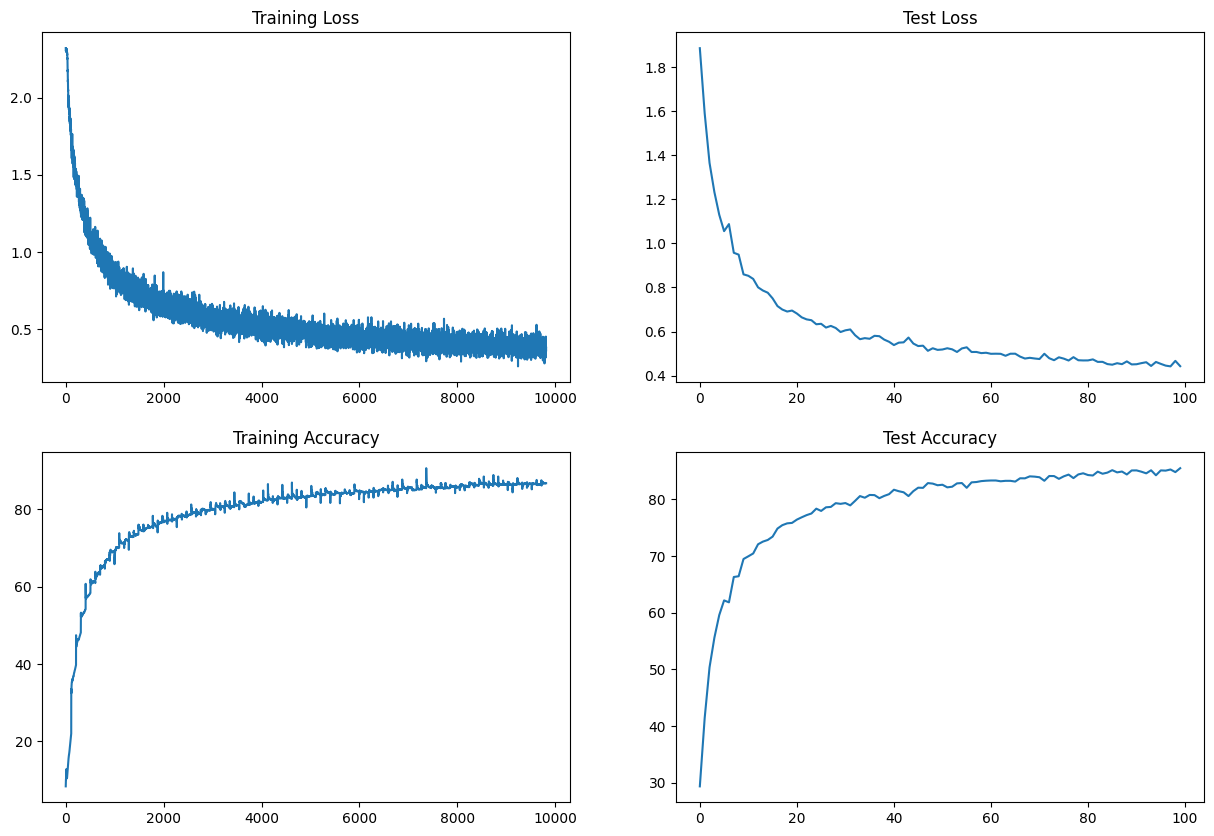

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")